## Import Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

!pip install ipython-autotime
%load_ext autotime

time: 354 µs (started: 2025-03-18 20:07:52 +00:00)


## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [ ]:
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:24<00:00, 23.2MB/s]


time: 1min 38s (started: 2025-03-18 20:07:54 +00:00)


In [ ]:
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

time: 205 ms (started: 2025-03-18 20:09:32 +00:00)


##Import the Excel File

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving stanford_cars_with_class_names.xlsx to stanford_cars_with_class_names.xlsx
time: 11.2 s (started: 2025-03-18 20:10:20 +00:00)


In [ ]:
excel_path = "stanford_cars_with_class_names.xlsx"

df_train = pd.read_excel(excel_path, sheet_name="train")
df_test = pd.read_excel(excel_path, sheet_name="test")

train_images_path = "/content/dataset/cars_train/cars_train"
test_images_path = "/content/dataset/cars_test/cars_test"

def add_image_paths(data, images_path):
    data['image_path'] = data['image'].apply(lambda img: os.path.join(images_path, img.strip("'")))
    return data

train_data = add_image_paths(df_train, train_images_path)
test_data = add_image_paths(df_test, test_images_path)

time: 1.87 s (started: 2025-03-18 20:10:31 +00:00)


In [ ]:
train_data.head(), test_data.head()

(   Unnamed: 0   x1   y1    x2    y2  class  \
 0           0   39  116   569   375     14   
 1           1   36  116   868   587      3   
 2           2   85  109   601   381     91   
 3           3  621  393  1484  1096    134   
 4           4   14   36   133    99    106   
 
                        ture_class_name      image  \
 0                  Audi TTS Coupe 2012  00001.jpg   
 1                  Acura TL Sedan 2012  00002.jpg   
 2           Dodge Dakota Club Cab 2007  00003.jpg   
 3     Hyundai Sonata Hybrid Sedan 2012  00004.jpg   
 4  Ford F-450 Super Duty Crew Cab 2012  00005.jpg   
 
                                          image_path  
 0  /content/dataset/cars_train/cars_train/00001.jpg  
 1  /content/dataset/cars_train/cars_train/00002.jpg  
 2  /content/dataset/cars_train/cars_train/00003.jpg  
 3  /content/dataset/cars_train/cars_train/00004.jpg  
 4  /content/dataset/cars_train/cars_train/00005.jpg  ,
     x1   y1   x2   y2  class                      ture_cla

time: 9.39 ms (started: 2025-03-18 20:10:33 +00:00)


In [ ]:
print(df_train.columns)

Index(['Unnamed: 0', 'x1', 'y1', 'x2', 'y2', 'class', 'ture_class_name',
       'image', 'image_path'],
      dtype='object')
time: 511 µs (started: 2025-03-18 20:10:33 +00:00)


In [ ]:
def preprocess_and_crop_images(data, src_folder, dst_folder):
    os.makedirs(dst_folder, exist_ok=True)

    for _, row in data.iterrows():
        src_path = os.path.join(src_folder, row['image'].strip("'"))
        dst_path = os.path.join(dst_folder, row['image'].strip("'"))

        if not os.path.exists(dst_path):
            with Image.open(src_path) as img:
                x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
                img = img.crop((x1, y1, x2, y2))
                img = img.resize((224, 224), Image.Resampling.LANCZOS)
                img.save(dst_path)

preprocess_and_crop_images(df_train, train_images_path, "/content/dataset/cropped_train")
preprocess_and_crop_images(df_test, test_images_path, "/content/dataset/cropped_test")

train_images_path = "/content/dataset/cropped_train"
test_images_path = "/content/dataset/cropped_test"

train_data = add_image_paths(df_train, "/content/dataset/cropped_train")
test_data = add_image_paths(df_test, "/content/dataset/cropped_test")

time: 2min (started: 2025-03-18 20:10:33 +00:00)


#Creating Dataset object for the CNN

In [ ]:
class CarsDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(
            train_images_path if 'train' in self.data.iloc[idx]['image_path'] else test_images_path,
            self.data.iloc[idx]['image'].strip("'")
        )
        label = int(self.data.iloc[idx]['class']) - 1
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data_split, val_data_split = train_test_split(test_data, test_size=0.5, random_state=42)

train_dataset = CarsDataset(train_data, transform=transform)
val_dataset = CarsDataset(val_data_split, transform=transform)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_dataset = CarsDataset(test_data_split, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train : {len(train_dataset)}")
print(f"Validation : {len(val_dataset)}")
print(f"Test : {len(test_dataset)}")

Train : 8144
Validation : 4021
Test : 4020
time: 11.2 ms (started: 2025-03-18 20:12:39 +00:00)


#Base Model - Experiment 1

This model is built on SqueezeNet1.1, a lightweight CNN optimized for efficient feature extraction. The feature extractor is frozen to retain pre-trained knowledge, while the classifier is modified to accommodate 196 car classes. A single 1×1 convolutional layer replaces the original classifier, ensuring efficient learning while maintaining computational efficiency.

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=196):
        super(BaseModel, self).__init__()

        self.base_model = models.squeezenet1_1(pretrained=True)

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
        self.num_classes = num_classes

        for param in self.base_model.classifier[1].parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)

time: 578 µs (started: 2025-03-18 20:12:41 +00:00)


#Training Setup

The model is trained using Cross-Entropy Loss, which is well-suited for multi-class classification. The Adam optimizer is used with a learning rate of 0.001, balancing convergence speed and stability. Training is set for 10 epochs, allowing the model to learn meaningful representations without excessive computation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseModel(num_classes=196).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 110MB/s]


time: 364 ms (started: 2025-03-18 20:12:43 +00:00)


#Model Training Process

Trains the model using forward pass, backpropagation, and validation. Tracks loss and accuracy to monitor performance and prevent overfitting.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_samples += inputs.size(0)

        val_epoch_loss = val_loss / val_samples
        val_epoch_acc = val_corrects.double() / val_samples
        # scheduler.step(val_accuracy)

        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc.item())

        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")

    return model, history

time: 1.26 ms (started: 2025-03-18 20:12:46 +00:00)


In [ ]:
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=epochs
)

Epoch 1/10
------------------------------
Train Loss: 5.2414, Train Acc: 0.0227
Val Loss: 5.0458, Val Acc: 0.0560

Epoch 2/10
------------------------------
Train Loss: 4.8009, Train Acc: 0.0685
Val Loss: 4.6168, Val Acc: 0.1010

Epoch 3/10
------------------------------
Train Loss: 4.3990, Train Acc: 0.1211
Val Loss: 4.3005, Val Acc: 0.1353

Epoch 4/10
------------------------------
Train Loss: 4.0610, Train Acc: 0.1632
Val Loss: 4.0466, Val Acc: 0.1766

Epoch 5/10
------------------------------
Train Loss: 3.8297, Train Acc: 0.2020
Val Loss: 3.9060, Val Acc: 0.1903

Epoch 6/10
------------------------------
Train Loss: 3.6523, Train Acc: 0.2288
Val Loss: 3.7764, Val Acc: 0.2089

Epoch 7/10
------------------------------
Train Loss: 3.4713, Train Acc: 0.2532
Val Loss: 3.6795, Val Acc: 0.2251

Epoch 8/10
------------------------------
Train Loss: 3.3906, Train Acc: 0.2774
Val Loss: 3.5697, Val Acc: 0.2425

Epoch 9/10
------------------------------
Train Loss: 3.2920, Train Acc: 0.2906


##Visualize - Accuracy & Loss

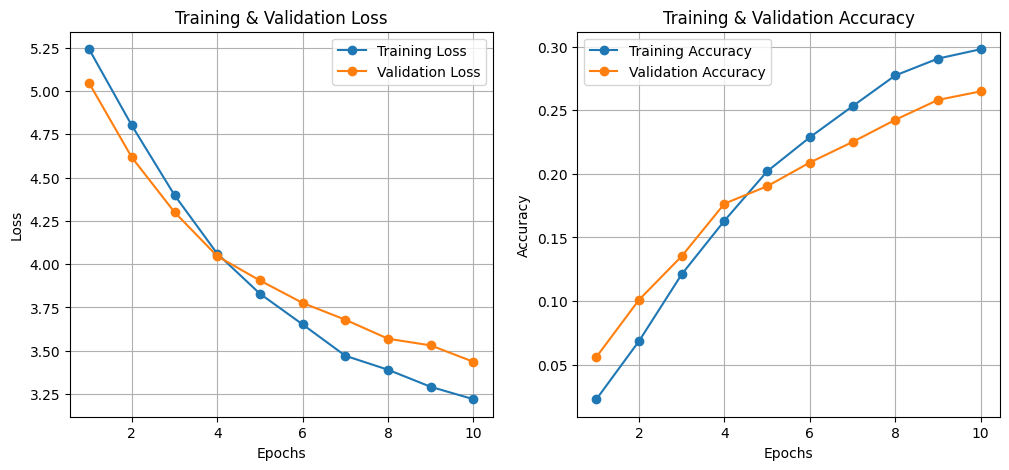

time: 255 ms (started: 2025-03-18 20:22:02 +00:00)


In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Training Accuracy", marker='o')
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

plot_training_history(training_history)

##Test - Base Model

 Test Accuracy: 0.2585
 Correct Predictions: 1039 / 4020
F1 Score: 0.2483


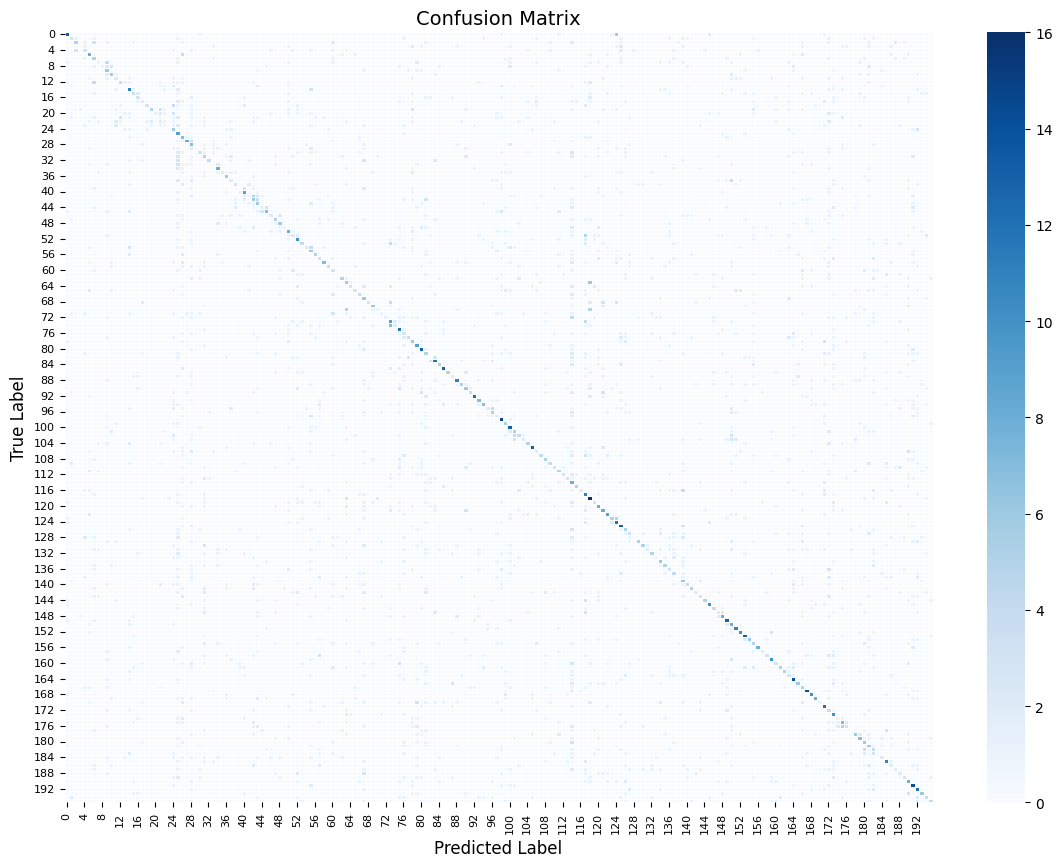

time: 19.4 s (started: 2025-03-18 20:22:03 +00:00)


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    correct_predictions = sum(np.array(true_labels) == np.array(predicted_labels))
    total_samples = len(true_labels)
    print(f" Test Accuracy: {accuracy:.4f}")
    print(f" Correct Predictions: {correct_predictions} / {total_samples}")

    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d", linewidths=0.5)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.show()

evaluate_model(model, test_loader, device)

Save Base Model Weights.

In [ ]:
torch.save(model.state_dict(), "experiment_1_weights.pth")

time: 20 ms (started: 2025-03-18 20:23:56 +00:00)


# Experiment 2

#Model Architecture

Uses MobileNetV2 with fine-tuning on later layers. Early layers are frozen to retain pre-trained features, while the classifier is customized with dropout and a linear layer for 196-class classification.

In [ ]:
class Experiment2(nn.Module):
    def __init__(self, num_classes=196, freeze_until=3):
        super(Experiment2, self).__init__()

        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

        for idx, param in enumerate(self.base_model.features.parameters()):
            if idx < freeze_until:
                param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )

        self.base_model.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)

time: 730 µs (started: 2025-03-18 20:23:57 +00:00)


#Training Configuration

The model is trained using CrossEntropyLoss with the Adam optimizer (learning rate = 0.001, weight decay = 1e-4) to improve generalization. Training is set for 20 epochs on GPU (if available).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Experiment2(num_classes=196).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 20

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 160MB/s]

time: 224 ms (started: 2025-03-18 20:23:57 +00:00)


In [ ]:
trained_model2, training_history2 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=epochs
)

Epoch 1/20
------------------------------
Train Loss: 4.8413, Train Acc: 0.0421
Val Loss: 3.9682, Val Acc: 0.1174

Epoch 2/20
------------------------------
Train Loss: 3.2827, Train Acc: 0.2277
Val Loss: 2.9066, Val Acc: 0.2983

Epoch 3/20
------------------------------
Train Loss: 2.4001, Train Acc: 0.4019
Val Loss: 2.2380, Val Acc: 0.4425

Epoch 4/20
------------------------------
Train Loss: 1.9712, Train Acc: 0.4998
Val Loss: 2.0084, Val Acc: 0.4938

Epoch 5/20
------------------------------
Train Loss: 1.7042, Train Acc: 0.5726
Val Loss: 1.8981, Val Acc: 0.5149

Epoch 6/20
------------------------------
Train Loss: 1.4867, Train Acc: 0.6181
Val Loss: 1.6538, Val Acc: 0.5848

Epoch 7/20
------------------------------
Train Loss: 1.4117, Train Acc: 0.6375
Val Loss: 1.5622, Val Acc: 0.6122

Epoch 8/20
------------------------------
Train Loss: 1.3167, Train Acc: 0.6596
Val Loss: 1.4462, Val Acc: 0.6351

Epoch 9/20
------------------------------
Train Loss: 1.1880, Train Acc: 0.6919


## Visualize - Accuarcy & Loss

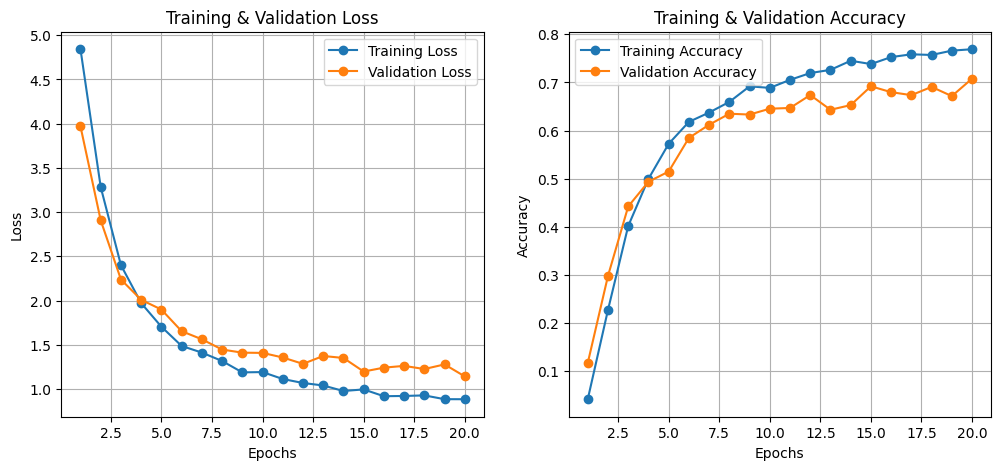

time: 270 ms (started: 2025-03-18 20:42:32 +00:00)


In [ ]:
plot_training_history(training_history2)

##Test - Experiment 2

 Test Accuracy: 0.6928
 Correct Predictions: 2785 / 4020
F1 Score: 0.6922


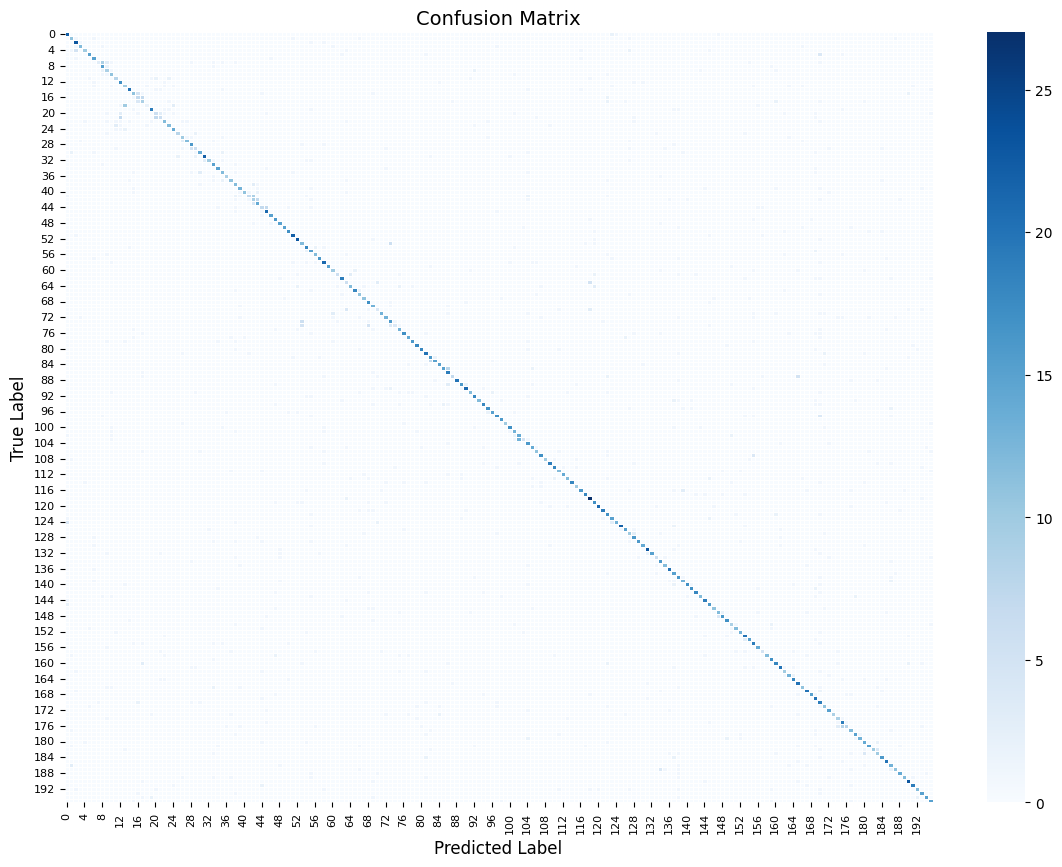

time: 19.1 s (started: 2025-03-18 20:42:32 +00:00)


In [ ]:
evaluate_model(trained_model2, test_loader, device)

Save Experiment 2 Weights.

In [ ]:
torch.save(model.state_dict(), "experiment_2_weights.pth")

time: 38.2 ms (started: 2025-03-18 20:42:51 +00:00)


#Experiment 3

#Model Architecture

This experiment employs EfficientNet-B0, leveraging its optimized depth-wise convolutions for efficient feature extraction. The classifier’s final layer is replaced with a fully connected layer matching the 196-class output. The base layers are frozen to retain pre-trained knowledge.

In [ ]:
class Experiment3(nn.Module):
    def __init__(self, num_classes=196):
        super(Experiment3, self).__init__()

        self.base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

time: 597 µs (started: 2025-03-18 20:43:01 +00:00)


#Training Configuration

The model is trained using Cross-Entropy Loss, optimized with Adam at a learning rate of 0.0001. This lower learning rate helps stabilize training by preventing drastic weight updates. The training is conducted for 20 epochs, allowing sufficient time for convergence.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Experiment3(num_classes=196).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 234MB/s]

time: 258 ms (started: 2025-03-18 20:43:01 +00:00)


In [ ]:
trained_model3, training_history3 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=epochs
)

Epoch 1/20
------------------------------
Train Loss: 5.2748, Train Acc: 0.0086
Val Loss: 5.2173, Val Acc: 0.0149

Epoch 2/20
------------------------------
Train Loss: 5.1920, Train Acc: 0.0156
Val Loss: 5.1553, Val Acc: 0.0266

Epoch 3/20
------------------------------
Train Loss: 5.1232, Train Acc: 0.0330
Val Loss: 5.1013, Val Acc: 0.0393

Epoch 4/20
------------------------------
Train Loss: 5.0636, Train Acc: 0.0462
Val Loss: 5.0384, Val Acc: 0.0619

Epoch 5/20
------------------------------
Train Loss: 5.0045, Train Acc: 0.0647
Val Loss: 4.9822, Val Acc: 0.0694

Epoch 6/20
------------------------------
Train Loss: 4.9456, Train Acc: 0.0775
Val Loss: 4.9445, Val Acc: 0.0876

Epoch 7/20
------------------------------
Train Loss: 4.8972, Train Acc: 0.0944
Val Loss: 4.8941, Val Acc: 0.1022

Epoch 8/20
------------------------------
Train Loss: 4.8502, Train Acc: 0.1027
Val Loss: 4.8557, Val Acc: 0.1055

Epoch 9/20
------------------------------
Train Loss: 4.8005, Train Acc: 0.1099


##Visualize - Accuarcy & Loss

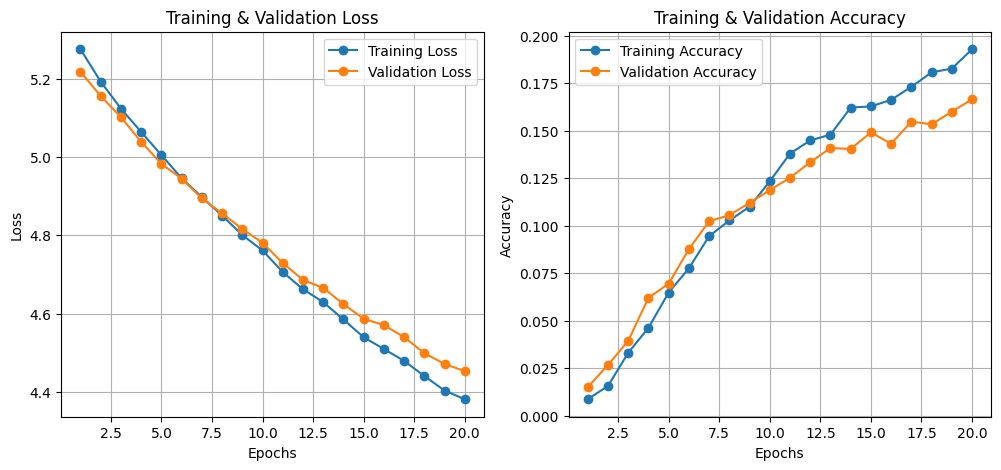

time: 262 ms (started: 2025-03-18 21:01:17 +00:00)


In [ ]:
plot_training_history(training_history3)

## Test - Experiment 3

 Test Accuracy: 0.1542
 Correct Predictions: 620 / 4020
F1 Score: 0.1352


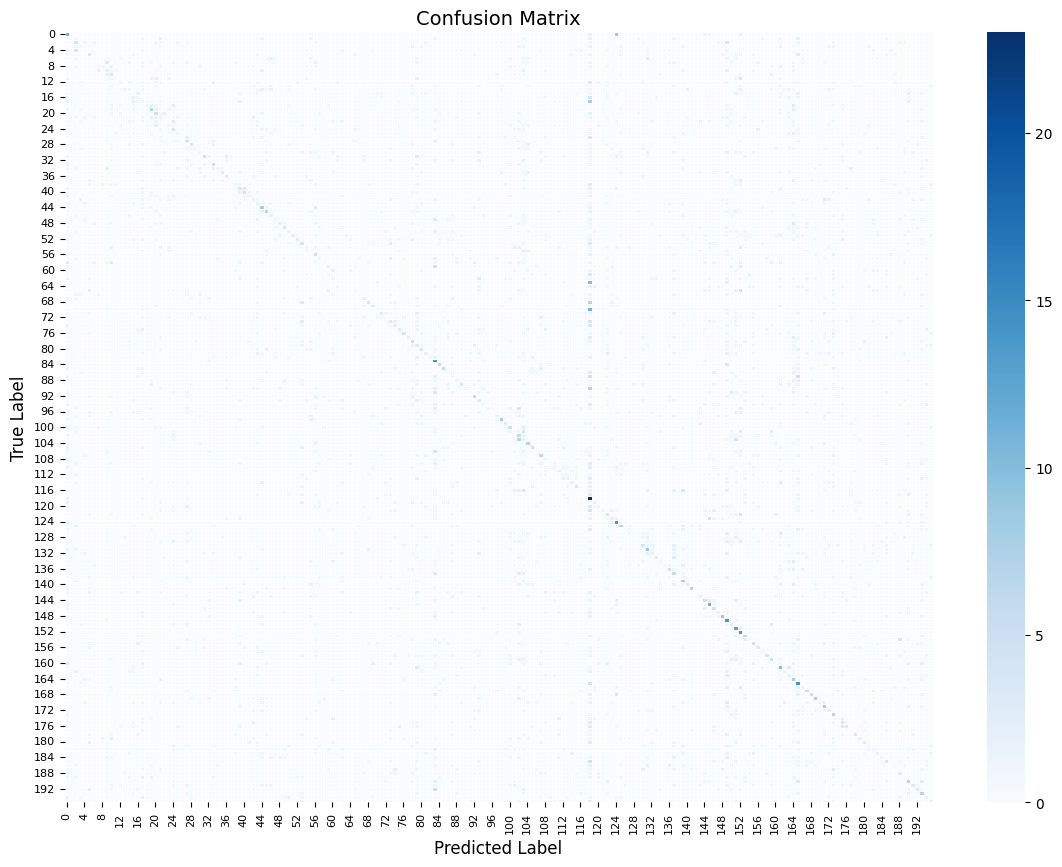

time: 18.8 s (started: 2025-03-18 21:01:18 +00:00)


In [ ]:
evaluate_model(trained_model3, test_loader, device)

In [ ]:
torch.save(model.state_dict(), "experiment_3_weights.pth")

time: 53.8 ms (started: 2025-03-18 21:01:36 +00:00)


#Compare between each experiment

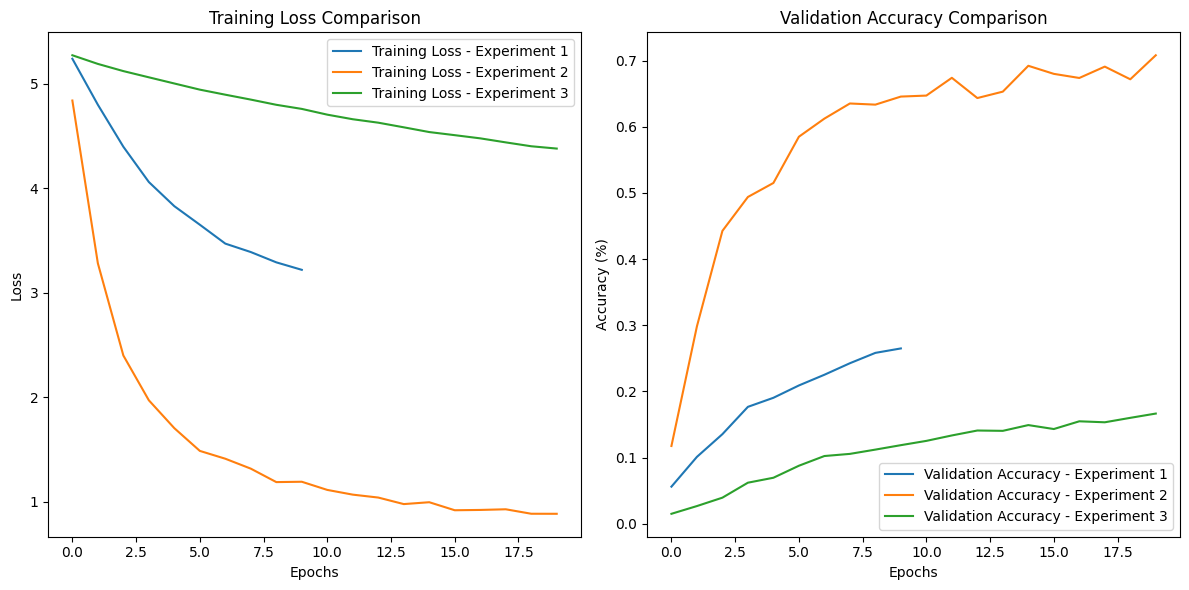

time: 310 ms (started: 2025-03-18 21:11:55 +00:00)


In [ ]:
def plot_results(histories, labels):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history['train_loss'], label=f'Training Loss - {label}')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history['val_acc'], label=f'Validation Accuracy - {label}')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

histories = [training_history, training_history2, training_history3]

labels = ['Experiment 1', 'Experiment 2', 'Experiment 3']

plot_results(histories, labels)

#Save best model weights & cropped images folders to Google Drive

In [ ]:
best_model = Experiment2(num_classes=196).to(device)
best_model.load_state_dict(torch.load("experiment_2_weights.pth", map_location=device))
best_model.eval()

<ipython-input-33-512191643206>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("experiment_2_weights.pth", map_location=device))


Experiment2(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

time: 315 ms (started: 2025-03-06 15:29:16 +00:00)


In [ ]:
%%capture
torch.save(best_model.state_dict(), '/content/drive/MyDrive/experiment_2_weights.pth')
!zip -r /content/drive/MyDrive/cropped_images.zip /content/dataset/cropped_train /content/dataset/cropped_test

Streaming output truncated to the last 5000 lines.
  adding: content/dataset/cropped_test/02082.jpg (deflated 1%)
  adding: content/dataset/cropped_test/04744.jpg (deflated 1%)
  adding: content/dataset/cropped_test/00458.jpg (deflated 1%)
  adding: content/dataset/cropped_test/00212.jpg (deflated 1%)
  adding: content/dataset/cropped_test/03773.jpg (deflated 1%)
  adding: content/dataset/cropped_test/06915.jpg (deflated 1%)
  adding: content/dataset/cropped_test/02386.jpg (deflated 1%)
  adding: content/dataset/cropped_test/06649.jpg (deflated 1%)
  adding: content/dataset/cropped_test/03975.jpg (deflated 2%)
  adding: content/dataset/cropped_test/02698.jpg (deflated 1%)
  adding: content/dataset/cropped_test/05147.jpg (deflated 1%)
  adding: content/dataset/cropped_test/03244.jpg (deflated 1%)
  adding: content/dataset/cropped_test/01785.jpg (deflated 2%)
  adding: content/dataset/cropped_test/04808.jpg (deflated 1%)
  adding: content/dataset/cropped_test/04643.jpg (deflated 2%)
  ad

#Test Environment

All required files are ready!

Upload an image to classify:


Saving 00001.jpg to 00001.jpg


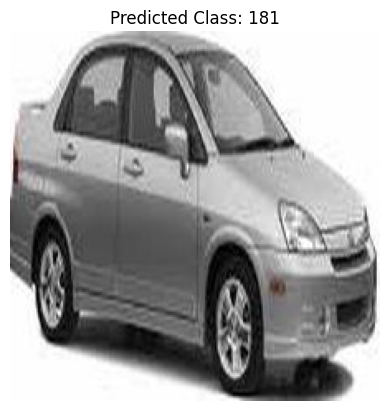

Image: 00001.jpg - Predicted Class: 181


In [ ]:
import gdown
import torch
import os
import zipfile
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import torch.nn as nn
import torchvision.models as models

weights_url = "https://drive.google.com/uc?id=11UJGYz81SwS8q0cjIq2wM32z4HGf5CbY"
images_zip_url = "https://drive.google.com/uc?id=1-0Ou_d-sWrn_30E-I75hf7hlcYyWKu_R"

weights_path = "experiment_2_weights.pth"
if not os.path.exists(weights_path):
    print("Downloading model weights...")
    gdown.download(weights_url, weights_path, quiet=False)

zip_path = "cropped_images.zip"
if not os.path.exists(zip_path):
    print("Downloading cropped images...")
    gdown.download(images_zip_url, zip_path, quiet=False)

dataset_path = "/content/dataset"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

print("All required files are ready!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Experiment2(nn.Module):
    def __init__(self, num_classes=196):
        super(Experiment2, self).__init__()
        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.base_model(x)

best_model = Experiment2(num_classes=196).to(device)
best_model.load_state_dict(torch.load(weights_path, map_location=device))
best_model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def classify_and_show_image(image_path):
    image_tensor = preprocess_image(image_path).to(device)

    with torch.no_grad():
        outputs = best_model(image_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()

    plt.imshow(Image.open(image_path))
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class + 1}")
    plt.show()

    return predicted_class + 1

upload_folder = "uploaded_test_images"
os.makedirs(upload_folder, exist_ok=True)

print("\nUpload an image to classify:")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, os.path.join(upload_folder, filename))

for filename in os.listdir(upload_folder):
    file_path = os.path.join(upload_folder, filename)
    predicted_class = classify_and_show_image(file_path)
    print(f"Image: {filename} - Predicted Class: {predicted_class}")